In [11]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

## Load Model 

In [12]:
from tensorflow import keras
model = keras.models.load_model('gru_model')

## Get Data For Products

In [13]:
from TDSCoinbaseData import TDSCoinbaseData
import logging
logging.getLogger().setLevel(level=logging.WARNING)

#reading dataset
cb_obj = TDSCoinbaseData(cache_path='data', notebook_logging=True)

# gets desired data and prepares it for modeling. 
def get_data(products, start_date, end_date, interval): 
    """
    Takes in a list of products and returns a mapping of product: dataframe for the given dates.
    """
    data_frames = {}
    for product in products:
        ## Only use overwrite=True when backfilling data. Otherwise, either specify overwrite=False or omit the arg entirely
        df = cb_obj.get_market_data(product, start_date, end_date, interval=interval, overwrite=False)
        data_frames[product] = df
    return data_frames
    

In [113]:
# actually getting the data: FOR PERIOD 1
products = ['BTC-USD', 'ETH-BTC', 'LTC-BTC', 'BCH-BTC', 'EOS-BTC']
start_date = '20201001'
end_date = '20201231'
interval = 3600
data_frames = get_data(products, start_date, end_date, interval)

Getting BTC-USD data from 20201001 to 20201231 at 3600s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 37.53 seconds
Getting ETH-BTC data from 20201001 to 20201231 at 3600s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 36.16 seconds
Getting LTC-BTC data from 20201001 to 20201231 at 3600s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 39.5 seconds
Getting BCH-BTC data from 20201001 to 20201231 at 3600s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 38.97 seconds
Getting EOS-BTC data from 20201001 to 20201231 at 3600s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 39.61 seconds


In [16]:
# actually getting the data: FOR PERIOD 2
start_date2 = '20200701'
end_date2 = '20200930'
interval2 = 60
data_frames2 = get_data(products, start_date, end_date, interval)
data_frames2

Getting BTC-USD data from 20201001 to 20201231 at 60s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 1.98 seconds
Getting ETH-BTC data from 20201001 to 20201231 at 60s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 1.44 seconds
Getting LTC-BTC data from 20201001 to 20201231 at 60s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 1.39 seconds
Getting BCH-BTC data from 20201001 to 20201231 at 60s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 1.16 seconds
Getting EOS-BTC data from 20201001 to 20201231 at 60s granularity


IntProgress(value=0, bar_style='info', description='Progress', max=92)

Completed in 1.16 seconds


{'BTC-USD':          timestamp       low      high      open     close     volume  \
 0       1601510400  10779.63  10788.50  10779.63  10783.24   3.506670   
 1       1601510460  10782.98  10799.99  10783.24  10796.02  15.461599   
 2       1601510520  10791.83  10798.73  10796.01  10795.06  17.630063   
 3       1601510580  10793.67  10799.99  10795.06  10799.99   2.646372   
 4       1601510640  10799.45  10829.99  10799.45  10817.42  47.834038   
 ...            ...       ...       ...       ...       ...        ...   
 132475  1609458900  29024.37  29044.52  29040.10  29041.80  19.654199   
 132476  1609458960  29035.43  29046.50  29041.80  29038.78   8.577417   
 132477  1609459020  29020.55  29041.89  29038.78  29036.91  11.842300   
 132478  1609459080  28989.22  29036.93  29036.92  28989.22  28.806245   
 132479  1609459140  28965.19  29020.06  28988.91  28990.08  21.178141   
 
                         datetime  product      date  
 0      2020-10-01 00:00:00+00:00  BTC-USD  

In [124]:
df = data_frames['ETH-BTC'] #INSERT PRODUCT HERE
df

,timestamp,low,high,open,close,volume,datetime,product,date
0,1601510400,0.03324,0.03374,0.03339,0.03330,1648.861947,2020-10-01 00:00:00+00:00,ETH-BTC,20201001
1,1601514000,0.03326,0.03339,0.03330,0.03339,221.167869,2020-10-01 01:00:00+00:00,ETH-BTC,20201001
2,1601517600,0.03343,0.03357,0.03343,0.03353,218.129777,2020-10-01 02:00:00+00:00,ETH-BTC,20201001
3,1601521200,0.03351,0.03358,0.03353,0.03357,522.173695,2020-10-01 03:00:00+00:00,ETH-BTC,20201001
4,1601524800,0.03352,0.03363,0.03355,0.03356,240.805079,2020-10-01 04:00:00+00:00,ETH-BTC,20201001
...,...,...,...,...,...,...,...,...,...
2203,1609441200,0.02548,0.02572,0.02562,0.02552,5658.295519,2020-12-31 19:00:00+00:00,ETH-BTC,20201231
2204,1609444800,0.02550,0.02559,0.02554,0.02555,2581.696190,2020-12-31 20:00:00+00:00,ETH-BTC,20201231
2205,1609448400,0.02535,0.02563,0.02556,0.02549,2097.763094,2020-12-31 21:00:00+00:00,ETH-BTC,20201231
2206,1609452000,0.02541,0.02552,0.02548,0.02545,1770.006442,2020-12-31 22:00:00+00:00,ETH-BTC,20201231


## Prepare Data for Modeling

In [125]:
df["datetime"] = pd.to_datetime(df["datetime"])
ind_df = df.set_index(["datetime"], drop=True)

# sorting the dataset in ascending order of date
data_frame = ind_df.sort_index(axis=1 ,ascending=True)

#filter to just closing price
data_frame = data_frame[["close"]]

#scale data by subtracting mean and dividing by STD
df_sc = StandardScaler()
test = df_sc.fit_transform(data_frame) # eth_test
#test = np.reshape(test, (1, len(test)))
data = test.reshape(test.shape[0], 1, test.shape[1]) # (106559, 1, 1) : eth_test_t

In [134]:
def prepare(dataframe, name): 
    
    df["datetime"] = pd.to_datetime(df["datetime"])
    ind_df = df.set_index(["datetime"], drop=True)

    # sorting the dataset in ascending order of date
    data_frame = ind_df.sort_index(axis=1 ,ascending=True)

    #filter to just closing price
    data_frame = data_frame[["close"]]
    test = df_sc.fit_transform(data_frame)
    data = test.reshape(test.shape[0], 1, test.shape[1]) # test_t
    
    prediction = model.predict(data)
    
    pred_scaled = df_sc.inverse_transform(prediction)
    test_scaled = df_sc.inverse_transform(test)
    
    #return test_scaled, pred_scaled, data
    
    reshaped = np.reshape(data, (len(data), 1))
    data_df = pd.DataFrame(reshaped, columns=[name])
    return data_df
    

times = [('20201001', '20201231'), ('20200701', '20200930'), ('20190601', '20190831')]
dataframes = []
#products = ['BTC-USD', 'ETH-BTC', 'LTC-BTC', 'BCH-BTC', 'EOS-BTC']
products = ['ETH-BTC', 'LTC-BTC', 'BCH-BTC', 'EOS-BTC']
interval = 3600 # hourly intervals 

for i in range(len(times)): 
    frames = get_data(products, time[i][0], time[i][1], interval)
    dfs = []
    for frame in frames.keys(): 
        dfs.append(prepare(frames[frame], frame))
    
    master_df = pd.concat(dfs, 1)
    master_df.head()


In [136]:
dfs = []
for frame in data_frames.keys(): 
    dfs.append(prepare(data_frames[frame], frame))
    
master_df = pd.concat(dfs, 1)

,BTC-USD,ETH-BTC,LTC-BTC,BCH-BTC,EOS-BTC
0,1.496517,1.496517,1.496517,1.496517,1.496517
1,1.536007,1.536007,1.536007,1.536007,1.536007
2,1.597436,1.597436,1.597436,1.597436,1.597436
3,1.614987,1.614987,1.614987,1.614987,1.614987
4,1.610599,1.610599,1.610599,1.610599,1.610599


In [147]:
master_df = pd.concat([data_frames['ETH-BTC']['timestamp'], 
                    data_frames['ETH-BTC']['datetime'],
                    master_df], 1)

    timestamp                  datetime   BTC-USD   ETH-BTC   LTC-BTC  \
0  1601510400 2020-10-01 00:00:00+00:00  0.032123  1.496517  1.496517   
1  1601514000 2020-10-01 01:00:00+00:00  0.032207  1.536007  1.536007   
2  1601517600 2020-10-01 02:00:00+00:00  0.032338  1.597436  1.597436   
3  1601521200 2020-10-01 03:00:00+00:00  0.032376  1.614987  1.614987   
4  1601524800 2020-10-01 04:00:00+00:00  0.032367  1.610599  1.610599   

    BCH-BTC   EOS-BTC  
0  1.496517  1.496517  
1  1.536007  1.536007  
2  1.597436  1.597436  
3  1.614987  1.614987  
4  1.610599  1.610599  


## Running Our Model on the Input

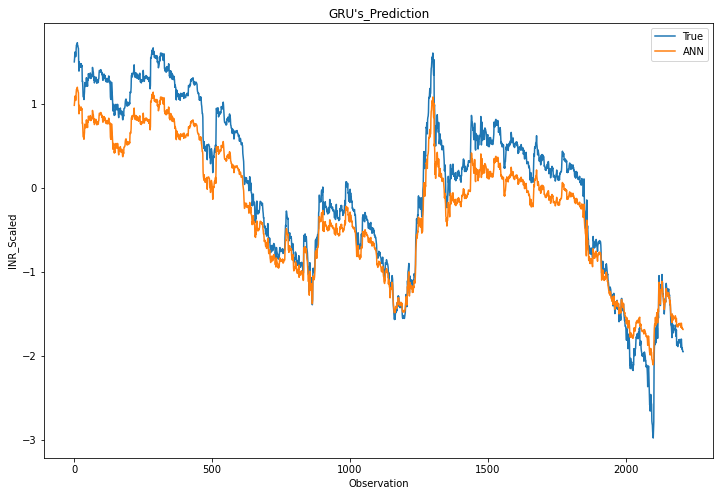

In [126]:
prediction = model.predict(data)

plt.figure(figsize=(12,8))
plt.plot(test, label='True')
plt.plot(prediction, label='ANN')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

## Unscale Normalized Output Back To Prices

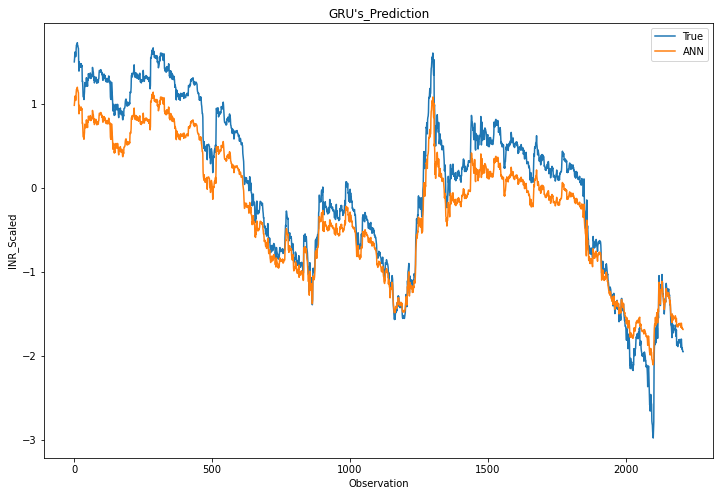

In [127]:
eth_pred_scaled = df_sc.inverse_transform(prediction)
eth_test_scaled = df_sc.inverse_transform(test)


plt.figure(figsize=(12,8))
plt.plot(test, label='True')
plt.plot(prediction, label='ANN')
plt.title("GRU's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

## Making Decisions Based on Our Predictions

In [156]:
K.clear_session() # clear model memory between disparate runs

def pred(num): 
    y = model.predict(np.reshape(np.array(num), (1, 1, 1)))
    y_scaled = df_sc.inverse_transform(y)
    return 1 / y_scaled[0, 0]

for frame in data_frames.keys():
    master_df[frame] = master_df[frame].apply(pred)
        
master_df['BTC-USD'] = 1 / master_df['BTC-USD']
master_df

KeyboardInterrupt: 

In [248]:
import decisions

agg_tuples = []

btc = decisions.max_profit(master_df['BTC-USD'])
dfs = [master_df['timestamp'], master_df['datetime'], pd.Series(btc)]
cols = ['timestamp', 'datetime', 'USD', 'ETH', 'LTC', 'BCH', 'EOS']

for col in master_df.columns[3:]: 
    res = decisions.max_profit(master_df[col])
    for elem in res: 
        agg_tuples.append(elem)
    dfs.append(pd.Series(res))

tuples = pd.concat(dfs, 1)[:574]
tuples.columns = cols

intervals = schedule_weighted_intervals(agg_tuples)

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False   True   True   True   True
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False   True   True   True   True
2        False     False  False  False  False  False  False
3        False  

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False 

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False  False  False  False  False

[574 rows x 7 columns]
     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False  

     timestamp  datetime    USD    ETH    LTC    BCH    EOS
0        False     False  False  False  False  False  False
1        False     False  False  False  False  False  False
2        False     False  False  False  False  False  False
3        False     False  False  False  False  False  False
4        False     False  False  False  False  False  False
..         ...       ...    ...    ...    ...    ...    ...
569      False     False  False  False  False  False  False
570      False     False  False  False  False  False  False
571      False     False  False  False  False  False  False
572      False     False  False  False  False  False  False
573      False     False  False   True   True   True   True

[574 rows x 7 columns]


     timestamp datetime  USD                          ETH  \
0          NaN      NaT  NaN  (4, 6, 0.11704720905297705)   
1          NaN      NaT  NaN                          NaN   
2          NaN      NaT  NaN                          NaN   
3          NaN      NaT  NaN                          NaN   
4          NaN      NaT  NaN                          NaN   
..         ...      ...  ...                          ...   
569        NaN      NaT  NaN                          NaN   
570        NaN      NaT  NaN                          NaN   
571        NaN      NaT  NaN                          NaN   
572        NaN      NaT  NaN                          NaN   
573        NaN      NaT  NaN                          NaN   

                             LTC                          BCH  \
0    (4, 6, 0.11704720905297705)  (4, 6, 0.11704720905297705)   
1                            NaN                          NaN   
2                            NaN                          NaN   
3      

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      Na

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      Na

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      Na

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  NaN
570        NaN      NaT  NaN  NaN  NaN  NaN  NaN
571        NaN      NaT  NaN  NaN  NaN  NaN  NaN
572        NaN      NaT  NaN  NaN  NaN  NaN  NaN
573        NaN      NaT  NaN  NaN  NaN  NaN  NaN

[574 rows x 7 columns]
     timestamp datetime  USD  ETH  LTC  BCH  EOS
0          NaN      NaT  NaN  NaN  NaN  NaN  NaN
1          NaN      NaT  NaN  NaN  NaN  NaN  NaN
2          NaN      NaT  NaN  NaN  NaN  NaN  NaN
3          NaN      NaT  NaN  NaN  NaN  NaN  NaN
4          NaN      NaT  NaN  NaN  NaN  NaN  NaN
..         ...      ...  ...  ...  ...  ...  ...
569        NaN      NaT  NaN  NaN  NaN  NaN  

     timestamp datetime  USD                                ETH  \
0          NaN      NaT  NaN                                NaN   
1          NaN      NaT  NaN                                NaN   
2          NaN      NaT  NaN                                NaN   
3          NaN      NaT  NaN                                NaN   
4          NaN      NaT  NaN                                NaN   
..         ...      ...  ...                                ...   
569        NaN      NaT  NaN                                NaN   
570        NaN      NaT  NaN                                NaN   
571        NaN      NaT  NaN                                NaN   
572        NaN      NaT  NaN                                NaN   
573        NaN      NaT  NaN  (2205, 2208, 0.07139855716802401)   

                                   LTC                                BCH  \
0                                  NaN                                NaN   
1                                  NaN   